#  Classify Two Images Whether They Have Parent-Child Relationship or Not

### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import torch
from torch import nn, optim
from torch import functional as F 
from torchvision import datasets, transforms, models
from PIL import Image
from glob import glob
import cv2
import sklearn
from sklearn import model_selection
from sklearn.decomposition import IncrementalPCA
import pickle as pk

use_cuda = torch.cuda.is_available()

### Load all pairs files into dataframes

In [16]:
### load all the pairs
fs_pairs = pd.read_csv('v0.1.2/lists/pairs/csv/fs-pairs.csv')
bb_pairs = pd.read_csv('v0.1.2/lists/pairs/csv/bb-pairs.csv')
fd_pairs = pd.read_csv('v0.1.2/lists/pairs/csv/fd-pairs.csv')
md_pairs = pd.read_csv('v0.1.2/lists/pairs/csv/md-pairs.csv')
ms_pairs = pd.read_csv('v0.1.2/lists/pairs/csv/ms-pairs.csv')
ss_pairs = pd.read_csv('v0.1.2/lists/pairs/csv/ss-pairs.csv')
gfgd_pairs = pd.read_csv('v0.1.2/lists/pairs/csv/gfgd-pairs.csv')
gfgs_pairs = pd.read_csv('v0.1.2/lists/pairs/csv/gfgs-pairs.csv')
gmgd_pairs = pd.read_csv('v0.1.2/lists/pairs/csv/gmgd-pairs.csv')
gmgs_pairs = pd.read_csv('v0.1.2/lists/pairs/csv/gmgs-pairs.csv')
sibs_pairs = pd.read_csv('v0.1.2/lists/pairs/csv/sibs-pairs.csv')
files = [
    fs_pairs,
    bb_pairs,
    fd_pairs,
    md_pairs,
    ms_pairs,
    ss_pairs,
    gfgd_pairs,
    gfgs_pairs,
    gmgd_pairs,
    gmgs_pairs,
    sibs_pairs,
]


### add labels to all the pairs
for file in files:
    file = add_labels_to_pairs(file)

### concat the files of pairs into a single file
pairs = concat_pairs(files)

### save that file
# save_pairs(pairs, 'pairs.csv')

In [39]:
### show how the path was taken
pairs = pd.read_csv('pairs.csv')

for i in range(6000, 6020):
    fid = pairs.iloc[i]['p1'][:5]
    m1 = pairs.iloc[i]['p1'][6:]
    m1id = pairs.iloc[i]['p1'][9:]
    m2 = pairs.iloc[i]['p2'][6:]
    m2id = pairs.iloc[i]['p2'][9:]
    mid = pd.read_csv('v0.1.2/FIDs/'+fid+'/mid.csv')
    relation = mid.iloc[int(m1id)-1][m2id]
    label = 0
    if relation == 1 or relation == 4:
        label = 1
    print('f', fid, 'm1', m1, 'm2', m2)
    print(label)
    

f F0355 m1 MID1 m2 MID3
0
f F0355 m1 MID3 m2 MID4
0
f F0357 m1 MID1 m2 MID8
0
f F0357 m1 MID1 m2 MID7
0
f F0357 m1 MID1 m2 MID3
0
f F0357 m1 MID3 m2 MID8
0
f F0357 m1 MID3 m2 MID7
0
f F0357 m1 MID7 m2 MID8
0
f F0359 m1 MID3 m2 MID4
0
f F0363 m1 MID4 m2 MID5
0
f F0372 m1 MID3 m2 MID4
0
f F0377 m1 MID1 m2 MID3
0
f F0377 m1 MID1 m2 MID8
0
f F0377 m1 MID1 m2 MID7
0
f F0377 m1 MID1 m2 MID5
0
f F0377 m1 MID3 m2 MID8
0
f F0377 m1 MID3 m2 MID7
0
f F0377 m1 MID3 m2 MID5
0
f F0377 m1 MID5 m2 MID8
0
f F0377 m1 MID5 m2 MID7
0


### Preprocessing Functions

##### Add a Label to each pair
1 if their relation is parent or child

In [7]:
def add_labels_to_pairs(pairs):
    labels = []
    for i in pairs.index:
        fid = pairs.iloc[i]['p1'][:5]
        m1 = pairs.iloc[i]['p1'][6:]
        m1id = pairs.iloc[i]['p1'][9:]
        m2 = pairs.iloc[i]['p2'][6:]
        m2id = pairs.iloc[i]['p2'][9:]
        mid = pd.read_csv('v0.1.2/FIDs/'+fid+'/mid.csv')
        relation = mid.iloc[int(m1id)-1][m2id]
        label = 0
        if relation == 1 or relation == 4:
            label = 1
        labels.append(label)
    pairs['label'] = labels
    return pairs

##### save a pair file into csv

In [11]:
def save_pairs(pairs, path):
    pairs.to_csv(path)

##### Concat multiple pairs files into 1 pair file

In [12]:
def concat_pairs(pairs_list):
    pairs = pairs_list[0]
    for p in pairs_list[1:]:
        pairs = pairs.append(p, ignore_index=True)
    return pairs

##### Take Single pair from a pairs file, turn this pair into all the combination of all image paths of this two pairs

In [8]:
### get all the paths of images of a single MID
def get_paths(pair):
    fid = pair['p1'][:5]
    m1 = pair['p1'][6:]
    m1id = pair['p1'][9:]
    m2 = pair['p2'][6:]
    m2id = pair['p2'][9:]
    paths1 = np.array(glob('v0.1.2/FIDs/'+fid+'/'+m1+'/*'))
    paths2 = np.array(glob('v0.1.2/FIDs/'+fid+'/'+m2+'/*'))
    ### get all combinations of two MID images
    mesh = np.array(np.meshgrid(paths1, paths2))
    combinations = mesh.T.reshape(-1, 2)
    return combinations

In [27]:
### Example of get paths
get_paths(pairs.iloc[99])

array([['v0.1.2/FIDs/F0074/MID3\\P11159_face0.jpg',
        'v0.1.2/FIDs/F0074/MID4\\P11162_face1.jpg'],
       ['v0.1.2/FIDs/F0074/MID3\\P11159_face0.jpg',
        'v0.1.2/FIDs/F0074/MID4\\P11165_face2.jpg'],
       ['v0.1.2/FIDs/F0074/MID3\\P11160_face1.jpg',
        'v0.1.2/FIDs/F0074/MID4\\P11162_face1.jpg'],
       ['v0.1.2/FIDs/F0074/MID3\\P11160_face1.jpg',
        'v0.1.2/FIDs/F0074/MID4\\P11165_face2.jpg'],
       ['v0.1.2/FIDs/F0074/MID3\\P11161_face0.jpg',
        'v0.1.2/FIDs/F0074/MID4\\P11162_face1.jpg'],
       ['v0.1.2/FIDs/F0074/MID3\\P11161_face0.jpg',
        'v0.1.2/FIDs/F0074/MID4\\P11165_face2.jpg'],
       ['v0.1.2/FIDs/F0074/MID3\\P11165_face1.jpg',
        'v0.1.2/FIDs/F0074/MID4\\P11162_face1.jpg'],
       ['v0.1.2/FIDs/F0074/MID3\\P11165_face1.jpg',
        'v0.1.2/FIDs/F0074/MID4\\P11165_face2.jpg']], dtype='<U39')

##### Split the pairs dataframe into pairs path images and the label of the two images

In [9]:
### pairs info into labels and images paths
def pairs_to_path_and_labels(pairs):
    images_pair_paths = []
    labels = []
    for index, pair in pairs.iterrows():
        pair_paths = get_paths(pair)
        pair_label = pair['label']
        for pair_path in pair_paths:
            images_pair_paths.append(pair_path)
            labels.append(pair_label)
    images_pair_paths = np.array(images_pair_paths)
    labels = np.array(labels)
    return images_pair_paths, labels

In [41]:
### Example
x, y = pairs_to_path_and_labels(pairs.iloc[:2])
print('x:\n', x)
print('y:\n', y)

x:
 [['v0.1.2/FIDs/F0002/MID2\\P00009_face1.jpg'
  'v0.1.2/FIDs/F0002/MID3\\P00009_face2.jpg']
 ['v0.1.2/FIDs/F0002/MID2\\P00009_face1.jpg'
  'v0.1.2/FIDs/F0002/MID3\\P00010_face2.jpg']
 ['v0.1.2/FIDs/F0002/MID2\\P00009_face1.jpg'
  'v0.1.2/FIDs/F0002/MID3\\P00011_face0.jpg']
 ['v0.1.2/FIDs/F0002/MID2\\P00009_face1.jpg'
  'v0.1.2/FIDs/F0002/MID3\\P00012_face2.jpg']
 ['v0.1.2/FIDs/F0002/MID2\\P00009_face1.jpg'
  'v0.1.2/FIDs/F0002/MID3\\P00013_face0.jpg']
 ['v0.1.2/FIDs/F0002/MID2\\P00009_face1.jpg'
  'v0.1.2/FIDs/F0002/MID3\\P00014_face1.jpg']
 ['v0.1.2/FIDs/F0002/MID2\\P00009_face1.jpg'
  'v0.1.2/FIDs/F0002/MID3\\P00015_face0.jpg']
 ['v0.1.2/FIDs/F0002/MID2\\P00009_face1.jpg'
  'v0.1.2/FIDs/F0002/MID3\\P00017_face0.jpg']
 ['v0.1.2/FIDs/F0002/MID2\\P00009_face1.jpg'
  'v0.1.2/FIDs/F0002/MID3\\P00018_face0.jpg']
 ['v0.1.2/FIDs/F0002/MID2\\P00010_face0.jpg'
  'v0.1.2/FIDs/F0002/MID3\\P00009_face2.jpg']
 ['v0.1.2/FIDs/F0002/MID2\\P00010_face0.jpg'
  'v0.1.2/FIDs/F0002/MID3\\P00010_face2.j

##### Prepare the data: read the pairs file, and return paths and labels

In [13]:
def data_prepration(pairs = None):
    if pairs is None:
        pairs = pd.read_csv('pairs.csv')
    images_pair_paths, labels = pairs_to_path_and_labels(pairs)
    return pairs, images_pair_paths, labels

### Custom Pytorch dataloaders: that return 2 images and a label on each iteration

In [2]:
class DataLoaderPairs(torch.utils.data.Dataset):
    def __init__(self, pairs_paths, lables, transform = None):
        super(DataLoaderPairs, self).__init__()
        self.images_pair_paths = pairs_paths
        self.lables = lables
        self.transform  = transform
        

    def __getitem__(self, index):
        label = self.lables[index]
        pair = self.images_pair_paths[index]
        data1 = Image.open(pair[0]).convert('RGB') ## read the image using PIL.Image
        data2 = Image.open(pair[1]).convert('RGB') ## read the image using PIL.Image
        ## if there is transformation apply it here
        if self.transform is not None:
            data1 = self.transform(data1)
            data2 = self.transform(data2)
        label = torch.tensor(label, dtype= torch.long) ## transform the label into tensor
        return data1, data2, label

    def __len__(self):
        return len(self.images_pair_paths)

In [42]:
### load pairs.csv, images paths and labels
pairs, paths, labels = data_prepration()

In [43]:
paths

array([['v0.1.2/FIDs/F0002/MID2\\P00009_face1.jpg',
        'v0.1.2/FIDs/F0002/MID3\\P00009_face2.jpg'],
       ['v0.1.2/FIDs/F0002/MID2\\P00009_face1.jpg',
        'v0.1.2/FIDs/F0002/MID3\\P00010_face2.jpg'],
       ['v0.1.2/FIDs/F0002/MID2\\P00009_face1.jpg',
        'v0.1.2/FIDs/F0002/MID3\\P00011_face0.jpg'],
       ...,
       ['v0.1.2/FIDs/F1018/MID7\\P13187_face4.jpg',
        'v0.1.2/FIDs/F1018/MID8\\P13185_face5.jpg'],
       ['v0.1.2/FIDs/F1018/MID7\\P13187_face4.jpg',
        'v0.1.2/FIDs/F1018/MID8\\P13186_face0.jpg'],
       ['v0.1.2/FIDs/F1018/MID7\\P13187_face4.jpg',
        'v0.1.2/FIDs/F1018/MID8\\P13187_face0.jpg']], dtype='<U41')

In [14]:
pairs

,Unnamed: 0,p1,p2,FID,label
0,0,F0002/MID2,F0002/MID3,F0002,1
1,1,F0003/MID3,F0003/MID1,F0003,1
2,2,F0003/MID3,F0003/MID4,F0003,1
3,3,F0004/MID3,F0004/MID4,F0004,1
4,4,F0004/MID3,F0004/MID5,F0004,1
...,...,...,...,...,...
8742,8742,F1018/MID4,F1018/MID7,F1018,0
8743,8743,F1018/MID4,F1018/MID8,F1018,0
8744,8744,F1018/MID5,F1018/MID8,F1018,0
8745,8745,F1018/MID5,F1018/MID7,F1018,0


In [ ]:
### save all labels into csv
np.savetxt('lables.csv', labels, delimiter=',')

In [ ]:
### save all paths into csv
np.savetxt('paths.csv', paths, delimiter=',', fmt="%s")

In [15]:
print("The ratio of ones in the Pairs file, before changing it to paths and images:", str(sum(pairs['label']) / len(pairs['label']) * 100)[:4]+"%")

The ratio of ones in the Pairs file, before changing it to paths and images: 57.8%


### Split the pairs dataframe into equal label split

In [59]:
### split the data by pairs, not by all the images
#### 80% train 20% test
train, test = model_selection.train_test_split(pairs, train_size=0.8, stratify=pairs['label'])
#### split the train set into 90% train 10% dev (vaildation)
train, dev = model_selection.train_test_split(train, train_size=0.9,  stratify=train['label'])

In [60]:
### Now from pairs into paths(x) and labels(y)
X_train_sp, Y_train_sp = pairs_to_path_and_labels(train)
X_test_sp, Y_test_sp = pairs_to_path_and_labels(test)
X_dev_sp, Y_dev_sp = pairs_to_path_and_labels(dev)

In [61]:
### save full data set splitted by pairs
np.savetxt('X_train_sp.csv', X_train_sp, delimiter=',', fmt="%s")
np.savetxt('Y_train_sp.csv', Y_train_sp, delimiter=',')
np.savetxt('X_test_sp.csv', X_test_sp, delimiter=',', fmt="%s")
np.savetxt('Y_test_sp.csv', Y_test_sp, delimiter=',')
np.savetxt('X_dev_sp.csv', X_dev_sp, delimiter=',', fmt="%s")
np.savetxt('Y_dev_sp.csv', Y_dev_sp, delimiter=',')

In [3]:
### Load the dataset splitted by pairs
X_train_sp = np.array(pd.read_csv('X_train_sp.csv', delimiter=',', header=None))
X_test_sp = np.array(pd.read_csv('X_test_sp.csv', delimiter=',', header=None))
X_dev_sp = np.array(pd.read_csv('X_dev_sp.csv', delimiter=',', header=None))

In [4]:
### Load the dataset by pairs
Y_train_sp = np.loadtxt('Y_train_sp.csv', delimiter=',')
Y_test_sp  = np.loadtxt('Y_test_sp.csv', delimiter=',') 
Y_dev_sp   = np.loadtxt('Y_dev_sp.csv', delimiter=',')

In [35]:
print('Train pairs images:', len(X_train_sp))
print('Test pairs images:', len(X_test_sp))
print('Dev pairs images:', len(X_dev_sp))

Train pairs images: 274243
Test pairs images: 67048
Dev pairs images: 26479


In [41]:
print("The ratio of ones in the Train set:", str(sum(Y_train_sp) / len(Y_train_sp) * 100)[:4]+"%")

The ratio of ones in the Train set: 60.2%


In [42]:
print("The ratio of ones in the Test set:", str(sum(Y_test_sp) / len(Y_test_sp) * 100)[:4]+"%")

The ratio of ones in the Test set: 67.3%


In [43]:
print("The ratio of ones in the Dev set:", str(sum(Y_dev_sp) / len(Y_dev_sp) * 100)[:4]+"%")

The ratio of ones in the Dev set: 68.8%


### Split the data based on the paths file not the pairs file

In [ ]:
## full data set
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(paths, labels, train_size=0.8, stratify=labels)
X_train, X_dev, Y_train, Y_dev = model_selection.train_test_split(X_train, Y_train, train_size=0.9,  stratify=Y_train)

In [ ]:
### save full data set
np.savetxt('X_train.csv', X_train, delimiter=',', fmt="%s")
np.savetxt('Y_train.csv', Y_train, delimiter=',')
np.savetxt('X_test.csv', X_test, delimiter=',', fmt="%s")
np.savetxt('Y_test.csv', Y_test, delimiter=',')
np.savetxt('X_dev.csv', X_dev, delimiter=',', fmt="%s")
np.savetxt('Y_dev.csv', Y_dev, delimiter=',')

In [44]:
### Load the dataset
X_train= np.array(pd.read_csv('X_train.csv', delimiter=',', header=None))
X_test = np.array(pd.read_csv('X_test.csv', delimiter=',', header=None))
X_dev = np.array(pd.read_csv('X_dev.csv', delimiter=',', header=None))

In [45]:
### Load the dataset
Y_train = np.loadtxt('Y_train.csv', delimiter=',')
Y_test  = np.loadtxt('Y_test.csv', delimiter=',') 
Y_dev   = np.loadtxt('Y_dev.csv', delimiter=',')

In [46]:
print('Train pairs images:', len(X_train))
print('Test pairs images:', len(X_test))
print('Dev pairs images:', len(X_dev))

Train pairs images: 264794
Test pairs images: 73554
Dev pairs images: 29422


In [47]:
print("The ratio of ones in the Train set:", str(sum(Y_train) / len(Y_train) * 100)[:4]+"%")

The ratio of ones in the Train set: 62.1%


In [48]:
print("The ratio of ones in the Test set:", str(sum(Y_test) / len(Y_test) * 100)[:4]+"%")

The ratio of ones in the Test set: 62.1%


In [49]:
print("The ratio of ones in the Dev set:", str(sum(Y_dev) / len(Y_dev) * 100)[:4]+"%")

The ratio of ones in the Dev set: 62.1%


In [9]:
## subset of the full data
X_train_sub, _, Y_train_sub, _ = model_selection.train_test_split(X_train, Y_train, train_size=0.5, stratify=Y_train)
X_dev_sub, _, Y_dev_sub, _ = model_selection.train_test_split(X_dev, Y_dev, train_size=0.5,  stratify=Y_dev)
X_test_sub, _, Y_test_sub, _ = model_selection.train_test_split(X_test, Y_test, train_size=0.5,  stratify=Y_test)

In [12]:
### save sub data set
np.savetxt('X_train_sub.csv', X_train_sub, delimiter=',', fmt="%s")
np.savetxt('Y_train_sub.csv', Y_train_sub, delimiter=',')
np.savetxt('X_test_sub.csv', X_test_sub, delimiter=',', fmt="%s")
np.savetxt('Y_test_sub.csv', Y_test_sub, delimiter=',')
np.savetxt('X_dev_sub.csv', X_dev_sub, delimiter=',', fmt="%s")
np.savetxt('Y_dev_sub.csv', Y_dev_sub, delimiter=',')

In [50]:
### Load the sub dataset
X_train_sub = np.array(pd.read_csv('X_train_sub.csv', delimiter=',', header=None))
X_test_sub = np.array(pd.read_csv('X_test_sub.csv', delimiter=',', header=None))
X_dev_sub = np.array(pd.read_csv('X_dev_sub.csv', delimiter=',', header=None))

In [51]:
### Load the sub dataset
Y_train_sub = np.loadtxt('Y_train_sub.csv', delimiter=',')
Y_test_sub  = np.loadtxt('Y_test_sub.csv', delimiter=',') 
Y_dev_sub   = np.loadtxt('Y_dev_sub.csv', delimiter=',')

In [52]:
print('Train pairs images:', len(X_train_sub))
print('Test pairs images:', len(X_test_sub))
print('Dev pairs images:', len(X_dev_sub))

Train pairs images: 132397
Test pairs images: 36777
Dev pairs images: 14711


In [53]:
print("The ratio of ones in the Train set:", str(sum(Y_train_sub) / len(Y_train_sub) * 100)[:4]+"%")

The ratio of ones in the Train set: 62.1%


In [54]:
print("The ratio of ones in the Test set:", str(sum(Y_test_sub) / len(Y_test_sub) * 100)[:4]+"%")

The ratio of ones in the Test set: 62.1%


In [55]:
print("The ratio of ones in the Dev set:", str(sum(Y_dev_sub) / len(Y_dev_sub) * 100)[:4]+"%")

The ratio of ones in the Dev set: 62.1%


### Create the Transormations and Dataloaders

In [5]:
### create data loaders
train_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomChoice([
        transforms.RandomCrop(224),
        transforms.CenterCrop(224)
    ]),
    transforms.RandomRotation(30),
    transforms.RandomHorizontalFlip(0.3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# train_dataloader = torch.utils.data.DataLoader(DataLoaderPairs(X_train_sub, Y_train_sub, train_transform), batch_size=14, shuffle=True, num_workers=0)
# dev_dataloader = torch.utils.data.DataLoader(DataLoaderPairs(X_dev_sub, Y_dev_sub, test_transform), batch_size=4, shuffle=True, num_workers=0)
# test_dataloader = torch.utils.data.DataLoader(DataLoaderPairs(X_test_sub, Y_test_sub, test_transform), batch_size=4, shuffle=True,num_workers=0)

# train_dataloader = torch.utils.data.DataLoader(DataLoaderPairs(X_train, Y_train, train_transform), batch_size=14, shuffle=True, num_workers=0)
# dev_dataloader = torch.utils.data.DataLoader(DataLoaderPairs(X_dev, Y_dev, test_transform), batch_size=4, shuffle=True, num_workers=0)
# test_dataloader = torch.utils.data.DataLoader(DataLoaderPairs(X_test, Y_test, test_transform), batch_size=4, shuffle=True,num_workers=0)

train_dataloader = torch.utils.data.DataLoader(DataLoaderPairs(X_train_sp, Y_train_sp, train_transform), batch_size=14, shuffle=True, num_workers=0)
dev_dataloader = torch.utils.data.DataLoader(DataLoaderPairs(X_dev_sp, Y_dev_sp, test_transform), batch_size=4, shuffle=True, num_workers=0)
test_dataloader = torch.utils.data.DataLoader(DataLoaderPairs(X_test_sp, Y_test_sp, test_transform), batch_size=4, shuffle=True,num_workers=0)

In [6]:
### loaders dict
loaders = {'train':train_dataloader, 'test':test_dataloader, 'valid':dev_dataloader}

In [7]:
print("Train set number of batches" , len(train_dataloader))
print("Dev set number of batches" , len(dev_dataloader))
print("Test set number of batches" , len(test_dataloader))

Train set number of batches 19589
Dev set number of batches 6620
Test set number of batches 16762


In [8]:
### Test Loader with large batch
test_dataloader_large = torch.utils.data.DataLoader(DataLoaderPairs(X_test_sp, Y_test_sp, test_transform), batch_size=10, shuffle=True,num_workers=0)

### Save & Load Model Function

In [9]:
def save_model(model, optimizer, min_valid_loss, scheduler, filepath):
    state = {
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict(),
        'min_valid_loss': min_valid_loss,
        'scheduler': scheduler.state_dict()
    }
    torch.save(state, filepath)

In [10]:
def load_model(filepath):
    state = torch.load(filepath)
    model.load_state_dict(state['state_dict'])
    optimizer.load_state_dict(state['optimizer'])
    min_valid_loss = state['min_valid_loss']
    scheduler.load_state_dict(state['scheduler'])
    return model, optimizer, scheduler, min_valid_loss
    

### Train and Test Functions

In [11]:
### train function
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
def train_model(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path, valid_loss_min = np.inf, validate_in = 1000, scheduler = None):
    """returns trained model"""
    train_loss_min = np.inf
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (img1, img2, target) in enumerate(loaders['train']):
            if (batch_idx + 1) == len(loaders['train']) and img1.size()[0] == 1:
                break
            # move to GPU
            if use_cuda:
                img1, img2, target = img1.cuda(), img2.cuda(), target.cuda()

            model.zero_grad()
            optimizer.zero_grad()
            output = model([img1, img2])
            loss = criterion(output, target)
            train_loss += (loss.item() - train_loss) / (batch_idx + 1)
            loss.backward()
            optimizer.step()
            if (batch_idx + 1) % 100 == 0:
                print('Train batch: {} \tTraining Loss: {:.6f}'.format(
                    batch_idx+1, 
                    train_loss,
                ))
                ### step the scheduler every 1000th batch
                if scheduler is not None and (batch_idx + 1 ) % 1000 == 0:
                    scheduler.step(train_loss)
                    print('stepped...')
        ######################    
        # validate the model #
        ######################
        model.eval()
        ### save the model if the training loss is less than the minimum training loss
        if train_loss < train_loss_min:
            train_loss_min = train_loss
            save_model(model, optimizer, train_loss_min, scheduler, "model_train_v3.pt")
            print('Train Model is Saved....')
        print('Started Validating...')
        for batch_idx, (img1, img2, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                img1, img2, target = img1.cuda(), img2.cuda(), target.cuda()
            ## update the average validation loss
            output = model([img1, img2])
            loss = criterion(output, target)
            valid_loss += (loss.item() - valid_loss) / (batch_idx + 1)
            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        ## save the model if validation loss has decreased
        if valid_loss < valid_loss_min:
            valid_loss_min = valid_loss
            save_model(model, optimizer, valid_loss_min, scheduler, save_path)
            print('Dev Model is Saved....')
        if (epoch) % 3 == 0:
            print('Started testing....')
            test_model(loaders, model, criterion, use_cuda)
    # return trained model
    return model

In [12]:
def test_model(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.
    ones = 0.
    model.eval()
    for batch_idx, (img1, img2, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            img1, img2, target = img1.cuda(), img2.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model([img1, img2])
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        ones += np.sum(np.squeeze(pred.cpu().numpy()))
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += target.size(0)
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))
    print('ones: {:.6f}\n'.format(ones/total))
    print('ones: '+str(ones)+'/'+str(total))

### Model Architucture

In [10]:
vgg16 = models.vgg16_bn(pretrained=True)

In [17]:
vgg16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

### The first model

In [13]:
use_cuda = torch.cuda.is_available()

class PairNet(nn.Module):
    def __init__(self):
        super(PairNet, self).__init__()
        self.features = models.vgg16_bn(pretrained=True).features
        # Bad experiment
        ### reduace the number of channels from 512 to 128 
#         self.depth_reduction = nn.Sequential(
#             nn.Conv2d(512, 256, (3, 3), padding=1),
#             nn.Conv2d(256, 256, (3, 3), padding=1),
# #             nn.Conv2d(256, 128, (3, 3), padding=1),
#         )
        self.dropout = nn.Dropout(0.5)
        self.relu = nn.ReLU()
        self.avgpool = nn.AdaptiveAvgPool2d(output_size=(4, 4))
        self.classifier = nn.Sequential(
            nn.Linear(16384, 4096),
            nn.BatchNorm1d(4096),
            self.relu,
            self.dropout,
            nn.Linear(4096, 4096),
            nn.BatchNorm1d(4096),
            self.relu,
            self.dropout,
            nn.Linear(4096, 1024),
            nn.BatchNorm1d(1024),
            self.relu,
            self.dropout,
            nn.Linear(1024, 2)
        )
        
        
    def forward(self, x):
        x[0] = self.features(x[0])
#         x[0] = self.depth_reduction(x[0])
        x[0] = self.avgpool(x[0])
        x[1] = self.features(x[1])
#         x[1] = self.depth_reduction(x[1])
        x[1] = self.avgpool(x[1])
        x[0] = x[0].view(-1, 8192)
        x[1] = x[1].view(-1, 8192)
        x = torch.cat((x[0], x[1]), 1)
        x = self.classifier(x)
        return x

model = PairNet()
# move tensors to GPU if CUDA is available
if use_cuda:
    model.cuda()

### The second model: Performed worse than the first

In [10]:
use_cuda = torch.cuda.is_available()

class PairNetV2(nn.Module):
    def __init__(self):
        super(PairNetV2, self).__init__()
        self.encode = models.vgg16_bn(pretrained=True)
        self.encode.classifier[6] = nn.Linear(4096, 4096)
        ### reduace the number of channels from 512 to 128
        self.dropout = nn.Dropout(0.5)
        self.relu = nn.ReLU()
        self.classifier = nn.Sequential(
#             nn.Linear(4096, 4096),
            nn.BatchNorm1d(8192),
            self.relu,
            self.dropout,
            nn.Linear(8192, 4096),
            nn.BatchNorm1d(4096),
            self.relu,
            self.dropout,
            nn.Linear(4096, 1024),
            nn.BatchNorm1d(1024),
            self.relu,
            self.dropout,
            nn.Linear(1024, 2)
        )
        
        
    def forward(self, x):
        x[0] = self.encode(x[0])
        x[1] = self.encode(x[1])
#         x[0] = x[0].view(-1, 12544)
#         x[1] = x[1].view(-1, 12544)
        x = torch.cat((x[0], x[1]), 1)
        x = self.classifier(x)
        return x

model = PairNetV2()
# move tensors to GPU if CUDA is available
if use_cuda:
    model.cuda()

In [12]:
### Stop the grad of the vgg cnn
for param in model.features.parameters():
    param.require_grad = False


In [13]:
### Stop the grad of the vgg cnn of the 2nd model
# for param in model.encode.parameters():
#     param.require_grad = False
# for param in model.encode.classifier[3:].parameters():
#     param.require_grad = True

### Define the loss function and the optimizer (really what makes the difference between success or failure)

In [14]:
criterion = nn.CrossEntropyLoss()
# params = list(model.classifier.parameters()) + list(model.encode.classifier[3:].parameters())  ## use this in case of using 2nd model
params = list(model.classifier.parameters()) + list(model.avgpool.parameters()) 
optimizer = optim.Adam(params, 0.001, weight_decay=0.01)

In [15]:
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, verbose=True, factor=0.8, threshold=0.0001)

### Start Training

In [21]:
model = train_model(100, loaders, model, optimizer, criterion, use_cuda, 'model-test_v3.pt', scheduler=scheduler)

<ipython-input-2-e3a587970c27>:17: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  label = torch.tensor(label, dtype= torch.long)


Train batch: 100 	Training Loss: 0.476716
Train batch: 200 	Training Loss: 0.477763
Train batch: 300 	Training Loss: 0.486157
Train batch: 400 	Training Loss: 0.483578
Train batch: 500 	Training Loss: 0.485677
Train batch: 600 	Training Loss: 0.489085
Train batch: 700 	Training Loss: 0.484790
Train batch: 800 	Training Loss: 0.481500
Train batch: 900 	Training Loss: 0.482839
Train batch: 1000 	Training Loss: 0.485067
stepped...
Train batch: 1100 	Training Loss: 0.486326
Train batch: 1200 	Training Loss: 0.486416
Train batch: 1300 	Training Loss: 0.486945
Train batch: 1400 	Training Loss: 0.487215
Train batch: 1500 	Training Loss: 0.487740
Train batch: 1600 	Training Loss: 0.487157
Train batch: 1700 	Training Loss: 0.488775
Train batch: 1800 	Training Loss: 0.488655
Train batch: 1900 	Training Loss: 0.488261
Train batch: 2000 	Training Loss: 0.489337
stepped...
Train batch: 2100 	Training Loss: 0.489923
Train batch: 2200 	Training Loss: 0.490303
Train batch: 2300 	Training Loss: 0.49032

KeyboardInterrupt: 

##### the cell below can be used to change the learning of the optimizer without reinitalizing (lossing other learned values in the optimizer)

In [16]:
optimizer
for param_group in optimizer.param_groups:
        param_group['lr'] = 0.00001

In [17]:
optimizer

SGD (
Parameter Group 0
    dampening: 0
    lr: 1e-05
    momentum: 0.2
    nesterov: False
    weight_decay: 0.01
)

In [18]:
optimizer.state_dict

<bound method Optimizer.state_dict of Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 4.355614296588023e-08
    weight_decay: 0.01
)>

In [16]:
### load a model
model, optimizer, scheduler, _ = load_model('model-manual.pt')
# _, _, _, valid_loss_min = load_model('model-test.pt')

In [19]:
### load a model
model, optimizer, scheduler, valid_loss_min = load_model('model-test_v3_80.pt')

### Test the Model

In [19]:
### test a model
output = test_model({'test': test_dataloader_large}, model, criterion, use_cuda)

<ipython-input-2-e3a587970c27>:17: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  label = torch.tensor(label, dtype= torch.long)


Test Loss: 0.442123


Test Accuracy: 80% (53835/67048)
ones: 0.728463

ones: 48842.0/67048.0


#### Check the result

In [17]:
test_iter = iter(test_dataloader_large)

<ipython-input-2-5696c8269061>:18: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  label = torch.tensor(label, dtype= torch.long) ## transform the label into tensor


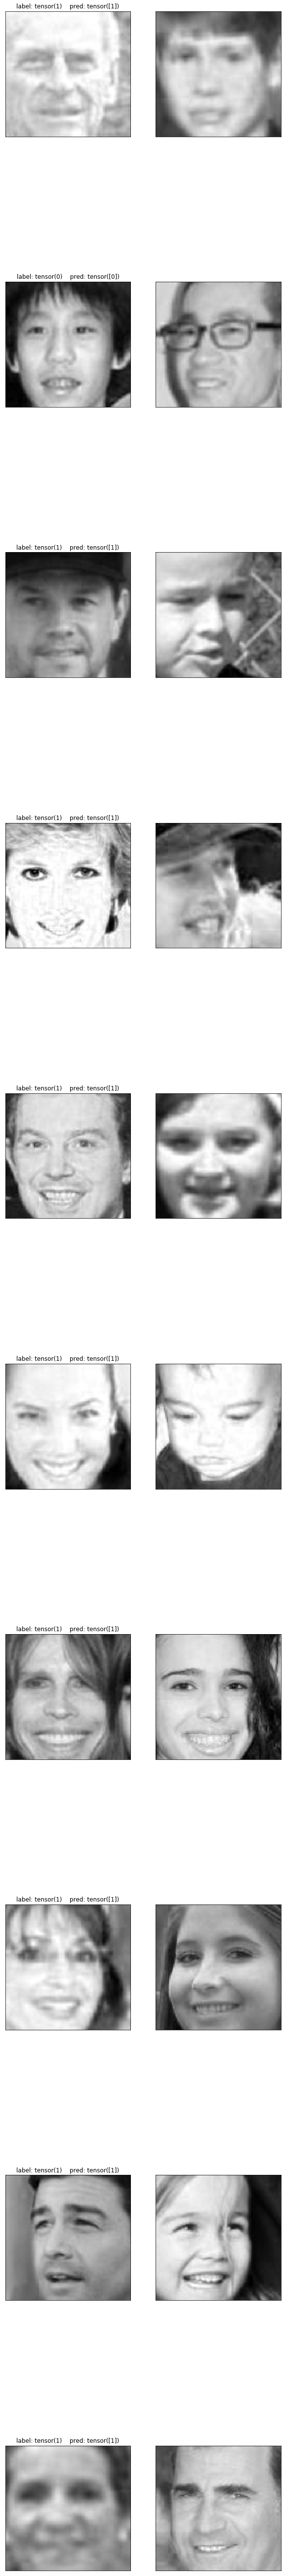

In [20]:
### look at some images
fig = plt.figure(figsize=(10, 200))
toPILImage = transforms.ToPILImage()
for i in range(10):
    img1, img2, label = next(test_iter)
    img1, img2, label = img1.cuda(), img2.cuda(), label.cuda()
    label = label[0]
    imgs = [img1, img2]
    predicted = model(imgs)
    predicted = predicted.cpu()
    pred = predicted.data.max(1, keepdim=True)[1][0]
#     print(predicted.data.max(1, keepdim=True))
    img1, img2, label = img1.cpu(), img2.cpu(), label.cpu()
    invTrans = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                                     std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                                transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ],
                                                     std = [ 1., 1., 1. ]),
                               ])

    img1 = invTrans(img1[0])
    img2 = invTrans(img2[0])
    img1 = toPILImage(img1[0])
    img2 = toPILImage(img2[0])
    imgs = [img1.convert('RGB'), img2.convert('RGB')]
    
    for j in range(0, 2):
        imgs1 = fig.add_subplot(20, 2, (i*2)+(j+1), xticks = [], yticks = [])
        imgs1.imshow(imgs[j])
        if j == 1:
            break
        imgs1.set_title("label: "+str(label)+"    pred: "+str(pred))
        